In [1]:
%load_ext autoreload
%autoreload 2
import os,sys
# ############################################################
# ### SPECIFIC FOR CUSTOM KERNEL FOR TF1
# ############################################################
sys.path.remove('/opt/xpu/python3.7')
sys.path.remove('/opt/mdsplus/7-92-0/pydevices')
sys.path.append('/theory/clau/.local/share/jupyter/kernels/tf_v1')
# ############################################################
# ############################################################

# add some modules to path
sys.path.append("/theory/clau/python")
sys.path.append("/theory/clau/c2w")
# Add parent directory to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)

import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("/theory/clau/")

/theory/clau


In [2]:
from SPIDER_mod.Burgers_Equation import analytical_solution
nu = 0.1 * 5
u_analytical, x, t = analytical_solution(5000, 501, 1.0, 2*np.pi, nu)
noise_level = 1e-1 * 1e-0

noise = noise_level * (
    (u_analytical.max()-u_analytical.min()) *
    np.random.randn(u_analytical.shape[0],u_analytical.shape[1])
)
u_noisy = u_analytical + noise

# noise = noise_level * (
#     np.random.randn(u_analytical.shape[0],u_analytical.shape[1])
# )
# u_noisy = u_analytical * (1 + noise)

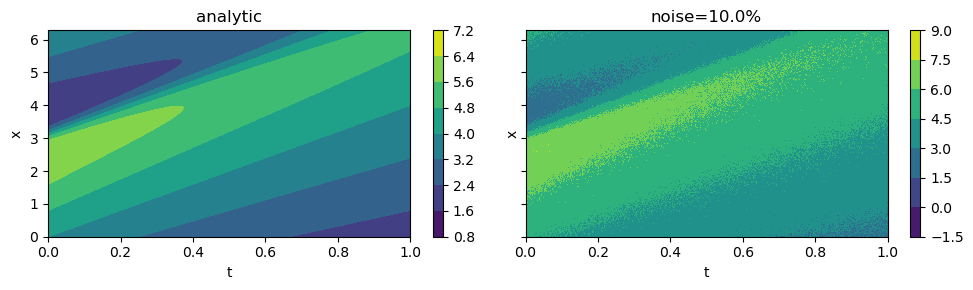

In [3]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, 
    sharex=True, sharey=True,
    figsize=(10,3), dpi=100
)
titles=['analytic', 'noise={}%'.format(noise_level*100)]
for ifig, u in enumerate([u_analytical, u_noisy]):
    cax=axs[ifig].contourf(
        t, x, u
    )
    axs[ifig].set(
        title=titles[ifig],
        xlabel='t', ylabel='x'
    )
    fig.colorbar(cax, ax=axs[ifig])
fig.tight_layout()
plt.show()

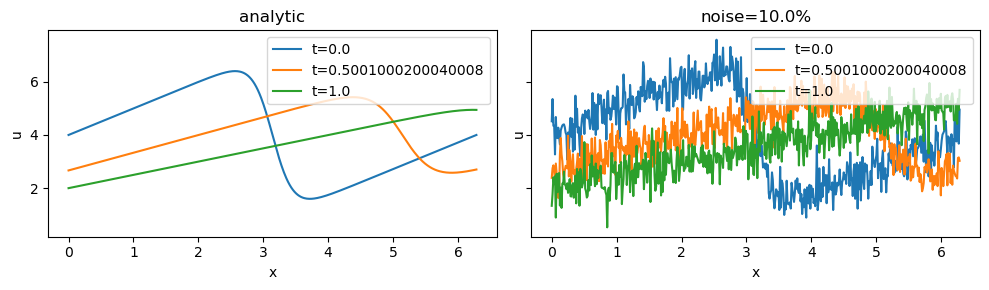

In [4]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, 
    sharex=True, sharey=True,
    figsize=(10, 3), dpi=100
)
titles=['analytic', 'noise={}%'.format(noise_level*100)]
for ifig, u in enumerate([u_analytical, u_noisy]):
    for i in [0,len(t)//2,-1]:
        axs[ifig].plot(
            x, u[:,i], label='t={}'.format(t[i])
        )
    axs[ifig].legend()
    axs[ifig].set(
        title=titles[ifig],
        xlabel='x', ylabel='u'
    )
fig.tight_layout()
plt.show()


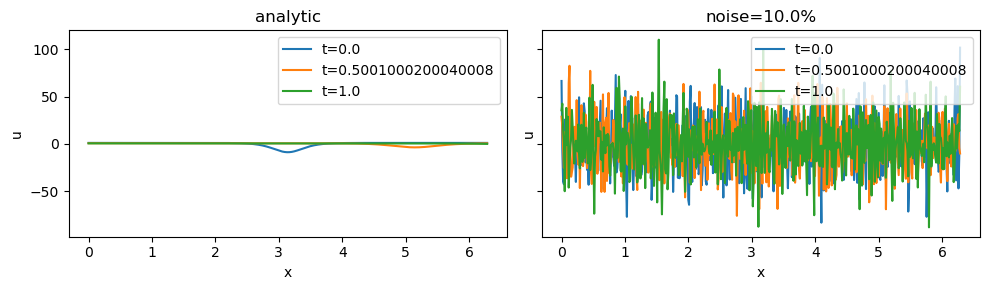

In [5]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, 
    sharex=True, sharey=True,
    figsize=(10, 3), dpi=100
)
titles=['analytic', 'noise={}%'.format(noise_level*100)]
for ifig, u in enumerate([u_analytical, u_noisy]):
    for i in [0,len(t)//2,-1]:
        axs[ifig].plot(
            x, np.gradient(u[:,i], x), 
            label='t={}'.format(t[i])
        )
    axs[ifig].legend()
    axs[ifig].set(
        title=titles[ifig],
        xlabel='x', ylabel='u'
    )
fig.tight_layout()
plt.show()


(75, 751)
(419,) (419,)


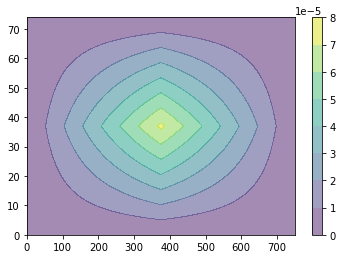

In [6]:
i0 = 0; i1 = u_noisy.shape[0]
j0 = 0; j1 = u_noisy.shape[1]
i_pow = 1
j_pow = 1

i_int_size = int(i1*0.15)
j_int_size = int(j1*0.15)

if(i_int_size%2==0):i_int_size+=1
if(j_int_size%2==0):j_int_size+=1

j_int_mesh, i_int_mesh = np.meshgrid(
    np.arange(j_int_size) - (j_int_size//2),
    np.arange(i_int_size) - (i_int_size//2),
)
i_int_weight = abs( i_int_mesh ).astype(float)
i_int_weight /= np.max(i_int_weight)
i_int_weight = np.power(1 - i_int_weight, i_pow)

j_int_weight = abs( j_int_mesh ).astype(float)
j_int_weight /= np.max(j_int_weight)
j_int_weight = np.power(1 - j_int_weight, j_pow)

integral_weight = i_int_weight * j_int_weight
integral_weight /= np.sum(integral_weight)

print(integral_weight.shape)

plt.contourf(integral_weight, alpha=0.5)
plt.colorbar()

N_samples = ( u_noisy.size // integral_weight.size ) * 10
# N_samples = u_noisy.shape[1]

eval_j0 = (
    np.unique(
        np.random.choice(
            np.arange(j0, j1-j_int_size, 1), 
            size=N_samples
        )
    )
)
eval_i0 = (
    (
        np.random.choice(
            np.arange(i0, i1-i_int_size, 1), 
            size=eval_j0.size
        )
    )
)
print(eval_i0.shape, eval_j0.shape)
plt.show()

In [7]:
def get_degrees_per_feature(poly_in, dimensions=2):
    # Make the names based on easy to use
    if dimensions == 2:
        variables = ["a", "b"]
    elif dimensions == 2:
        variables = ["a", "b", "c"]
    feat_names = poly_in.get_feature_names(variables)
    degrees = np.zeros((len(feat_names), len(variables)), dtype=int)
    for i, feat_name in enumerate(feat_names):
        for j, dim in enumerate(variables):
            # Check for first dimension
            if variables[j] not in feat_name:
                degrees[i, j] = 0
            elif (variables[j] in feat_name) and (variables[j] + "^" not in feat_name):
                degrees[i, j] = 1
            elif variables[j] + "^" in feat_name:
                degrees[i, j] = feat_name[
                    feat_name.find(variables[j] + "^") + len(variables[j] + "^")
                ]
    return degrees


def weighted_multivariate_polyfit(X, y, w, poly_degree=1, thresh=1e-10):
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures

    # Set up multivariate polynomial base from input X
    poly = PolynomialFeatures(degree=poly_degree, include_bias=True)
    X_poly = poly.fit_transform(X)
    
    # fit WLS using weights
    WLS = LinearRegression()
    WLS.fit(X_poly, y, sample_weight=w)
    
    # kill any coefficients below threshold
    WLS.coef_[abs(WLS.coef_) < thresh] = 0.0

    # dictionary will contain coefficients, feature names, score(?)
    WMP = dict(
        coefs=np.copy(WLS.coef_),
        degrees=get_degrees_per_feature(poly, dimensions=X.shape[1]),
        X=np.copy(X),
    )
    
    # not sure why, but the coefficient seems to be wrong for the bias
    WLS_mean = np.sum(weighted_multivariate_polypredict(WMP, dx=[0, 0]) * w) / np.sum(w)
    f_mean = np.sum(y * w) / np.sum(w)
    WMP['coefs'][0] += f_mean - WLS_mean

    return WMP

def weighted_multivariate_polypredict(WMP, dx=[0, 0]):
    coefs = np.copy(WMP["coefs"])
    # print(coefs.T)
    degrees = np.copy(WMP["degrees"])
    for i in range(degrees.shape[1]):
        for j in range(dx[i]):
            coefs[:] *= degrees[:, i]
            degrees[:, i] -= 1
            degrees[degrees[:, i] < 0, i] = 0
    pred = np.zeros_like(WMP["X"][:, 0])
    for i in range(degrees.shape[0]):
        this_term = np.ones_like(pred)
        for j in range(degrees.shape[1]):
            this_term[:] *= WMP["X"][:, j] ** degrees[i, j]
        pred[:] += coefs[i] * this_term
    # print(coefs)
    # print(degrees.T)
    # print()
    return pred

/tmp/ipykernel_7885/3661814288.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(
/tmp/ipykernel_7885/3661814288.py:46: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(
/tmp/ipykernel_7885/3661814288.py:53: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud',

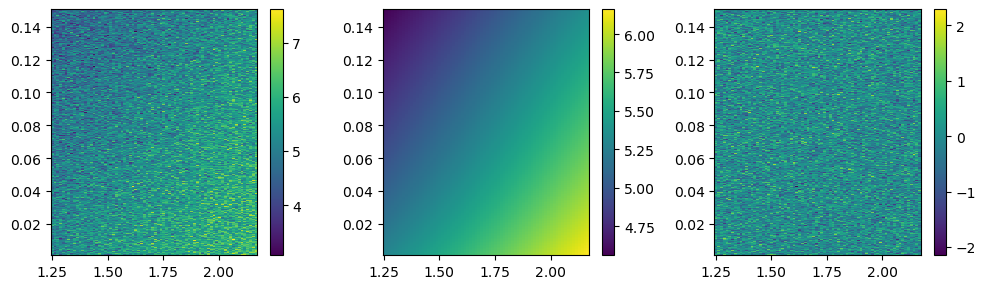

In [8]:
u=[]; u_t=[]; u_tt=[]; u_x=[]; u_xx=[];
u_t_clean=[];
t_points=[]; x_points=[];

from scipy.interpolate import SmoothBivariateSpline as Bspline

for _i, _j in zip(eval_i0[0:1], eval_j0[0:1]):
    x_points.append(x[_i]);
    t_points.append(t[_j]);
    _x_1d = x[_i:_i+i_int_size]
    _t_1d = t[_j:_j+j_int_size]
    _tt, _xx = np.meshgrid(
         _t_1d, _x_1d,
    )
    _X = np.vstack((_xx.flatten(), _tt.flatten())).T
    _f = np.copy(u_noisy[_i:_i+i_int_size,_j:_j+j_int_size].flatten())
    
    WMP = weighted_multivariate_polyfit(
        _X, _f, 
        # np.ones_like(integral_weight.flatten()), 
        integral_weight.flatten(), 
        # poly_degree=max(i_pow, j_pow)
        poly_degree=3
    )
    
    _u = weighted_multivariate_polypredict(WMP, dx=[0, 0]).reshape(_xx.shape)
    _u_x = weighted_multivariate_polypredict(WMP, dx=[1, 0]).reshape(_xx.shape)
    _u_xx = weighted_multivariate_polypredict(WMP, dx=[2, 0]).reshape(_xx.shape)
    _u_t = weighted_multivariate_polypredict(WMP, dx=[0, 1]).reshape(_xx.shape)
    _u_tt = weighted_multivariate_polypredict(WMP, dx=[0, 2]).reshape(_xx.shape)
    
    u.append( np.sum(_u * integral_weight) )
    u_t.append( np.sum(_u_t * integral_weight) )
    u_tt.append( np.sum(_u_tt * integral_weight) )
    u_x.append( np.sum(_u_x * integral_weight) )
    u_xx.append( np.sum(_u_xx * integral_weight) )
    
    plt.figure(figsize=(10,3), dpi=100)
    plt.subplot(131)
    plt.pcolormesh(
        _xx, _tt, _f.reshape(_xx.shape)
    )
    plt.colorbar()
    
    plt.subplot(132)
    plt.pcolormesh(
        _xx, _tt, 
        _u #+ 11.88
    )
    plt.colorbar()
    
    plt.subplot(133)
    plt.pcolormesh(
        _xx, _tt, 
        _u - _f.reshape(_xx.shape)
    )
    plt.colorbar()
    
    plt.tight_layout()
        

In [9]:
inputs = dict({
    "u" : [], 
    "u_t" : [], 
    "u_tt" : [], 
    "u_x" : [], 
    "u_xx" : [],
    "u u" : [],
    "u u_t" : [],
    "u u_x" : [],
    "u u_tt" : [],
    "u u_xx" : [],
    "u_t u_t" : [],
    "u_t u_x" : [],
    "u_x u_x" : [],
    "t" : [], 
    "x" : []
})
from scipy.interpolate import SmoothBivariateSpline as Bspline

for _i, _j in zip(eval_i0[:], eval_j0[:]):
    inputs["x"].append(x[_i]);
    inputs["t"].append(t[_j]);
    _x_1d = x[_i:_i+i_int_size]
    _t_1d = t[_j:_j+j_int_size]
    _tt, _xx = np.meshgrid(
         _t_1d, _x_1d,
    )
    _X = np.vstack((_xx.flatten(), _tt.flatten())).T
    
    WMP = weighted_multivariate_polyfit(
        _X, 
        u_noisy[_i:_i+i_int_size,_j:_j+j_int_size].flatten(), 
        integral_weight.flatten(), 
        # poly_degree=max(i_pow, j_pow)
        poly_degree=3
    )
    
    _u = weighted_multivariate_polypredict(WMP, dx=[0, 0]).reshape(_xx.shape)
    _u_x = weighted_multivariate_polypredict(WMP, dx=[1, 0]).reshape(_xx.shape)
    _u_xx = weighted_multivariate_polypredict(WMP, dx=[2, 0]).reshape(_xx.shape)
    _u_t = weighted_multivariate_polypredict(WMP, dx=[0, 1]).reshape(_xx.shape)
    _u_tt = weighted_multivariate_polypredict(WMP, dx=[0, 2]).reshape(_xx.shape)
    
    inputs["u"].append( np.sum(_u * integral_weight) )
    inputs["u_t"].append( np.sum(_u_t * integral_weight) )
    inputs["u_tt"].append( np.sum(_u_tt * integral_weight) )
    inputs["u_x"].append( np.sum(_u_x * integral_weight) )
    inputs["u_xx"].append( np.sum(_u_xx * integral_weight) )
    
    inputs["u u"].append( np.sum(_u * _u * integral_weight) )
    inputs["u u_t"].append( np.sum(_u * _u_t * integral_weight) )
    inputs["u u_tt"].append( np.sum(_u * _u_tt * integral_weight) )
    inputs["u u_x"].append( np.sum(_u * _u_x * integral_weight) )
    inputs["u u_xx"].append( np.sum(_u * _u_xx * integral_weight) )
    
    inputs["u_t u_t"].append( np.sum(_u_t * _u_t * integral_weight) )
    inputs["u_t u_x"].append( np.sum(_u_t * _u_x * integral_weight) )
    inputs["u_x u_x"].append( np.sum(_u_x * _u_x * integral_weight) )

In [10]:
U = []
feat_names = []
for key, val in inputs.items():
    if("u" in key):
        if(
            ("u_t" in key) and
            (" " not in key) and
            ("tt" not in key)
        ):
            continue
        else:
            U.append(val)
            feat_names.append(key)
feat_names = ['u_t'] + feat_names
print(feat_names)
U = np.array(U).T
X_dot = np.array([inputs['u_t']]).T
X = np.array([inputs['x']]).T
T = np.array([inputs['t']]).T

ind = np.argsort(T[:,0])
T = T[ind,:]
X = X[ind,:]
U = U[ind,:]
X_dot = X_dot[ind,:]

print(U.shape, X.shape, T.shape, X_dot.shape, len(feat_names))

['u_t', 'u', 'u_tt', 'u_x', 'u_xx', 'u u', 'u u_t', 'u u_x', 'u u_tt', 'u u_xx', 'u_t u_t', 'u_t u_x', 'u_x u_x']
(419, 12) (419, 1) (419, 1) (419, 1) 13


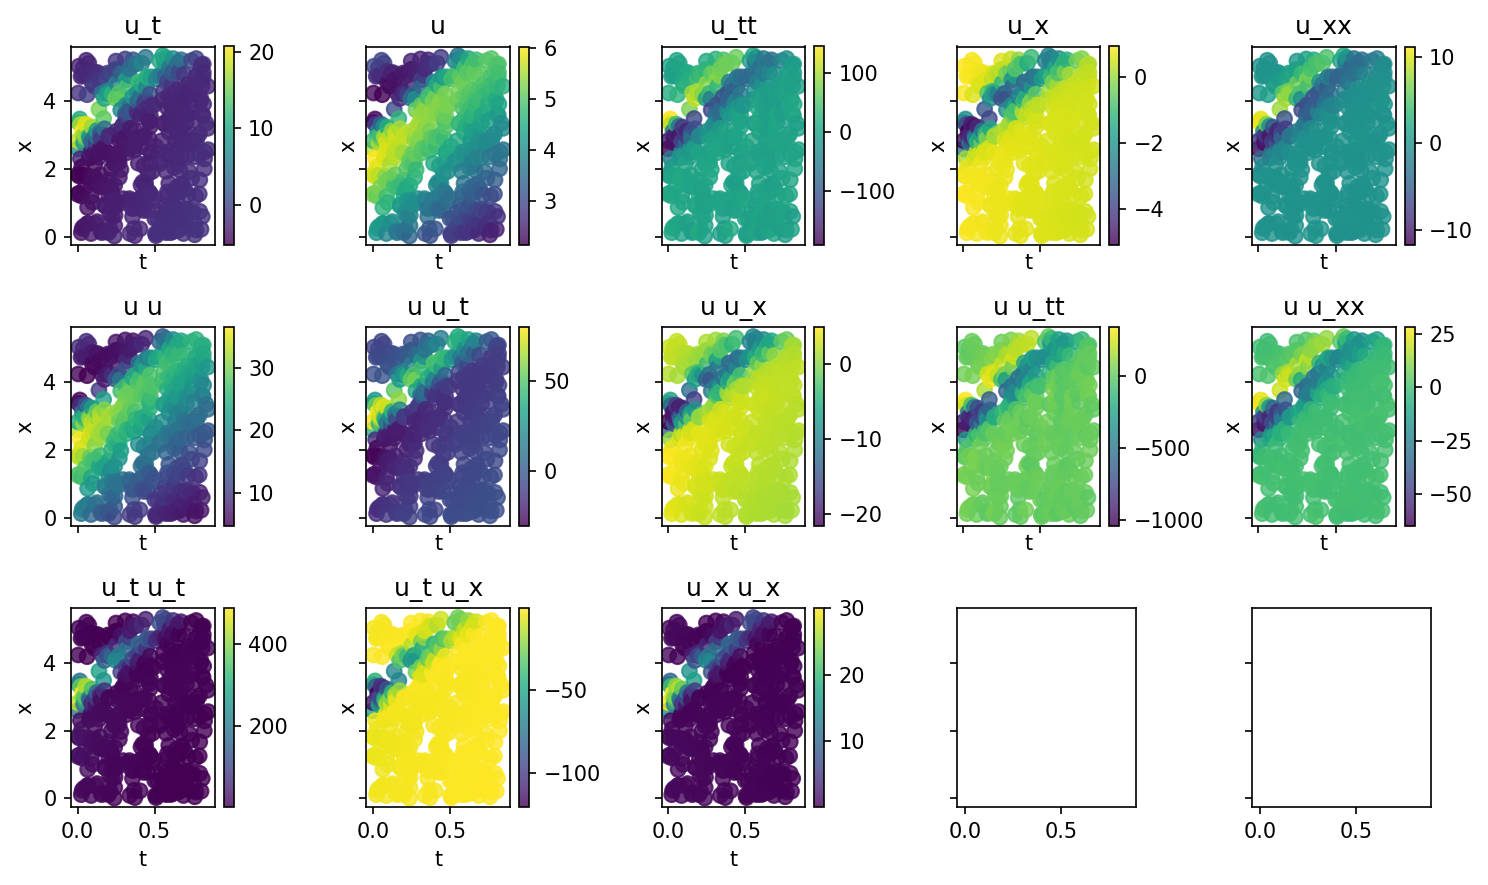

In [11]:
fig, axs = plt.subplots(
    nrows=int(np.ceil(len(feat_names)/5)), 
    ncols=5, 
    figsize=(10,6), dpi=150,
    sharex=True, sharey=True
)
axs = axs.flatten()
for ifig, key in enumerate( 
    feat_names 
):
    ax = axs[ifig]
    ax.set(
        title=key, xlabel='t', ylabel='x'
    )
    cax=ax.scatter(
        inputs['t'], inputs['x'], c=inputs[key], s=50, alpha=0.8
    )
    fig.colorbar(cax,ax=ax)
fig.tight_layout()
plt.show()

In [12]:
# N_terms = []
# score = []
# from optimizers import STLSQ_mod
# for num_terms in range(1,6):
#     lib = ps.IdentityLibrary()
#     opt = STLSQ_mod(
#         threshold=np.power(10,0.0), 
#         alpha=0, 
#         target_number_terms=num_terms, max_iter=100
#     )
#     model = ps.SINDy(
#         feature_names=feat_names,
#         optimizer=opt,
#         feature_library=lib
#     )
#     model.fit(X, t=T, x_dot=X_dot, u=U)
#     # pred = model.predict(X, u=U).flatten()
#     # score.append(
#     #     np.sum(
#     #         np.abs(
#     #             np.nan_to_num( (pred - u_t)
#     #         )
#     #     )
#     # ) / np.sum(abs(np.array(u_t))) )
#     score.append(model.score(X, t=T, x_dot=X_dot, u=U))
#     N_terms.append(model.complexity)
#     print()
#     model.print(lhs=['u_t'])
# print(score)
# print(N_terms)

In [13]:
T = np.copy(inputs['t'])
ind = np.argsort(T)
# U = np.vstack((u_tt, u_x, u_xx)).T[ind,:]
U = np.vstack((inputs['u_x'], inputs['u_xx'])).T[ind,:]
X = np.vstack(tuple(inputs['u']))[ind,:]
X_dot = np.vstack(tuple(inputs['u_t']))[ind,:]
print(U.shape, X.shape, X_dot.shape)
print(T.shape)
print(np.unique(T).shape)

(419, 2) (419, 1) (419, 1)
(419,)
(419,)


In [14]:
N_terms = []
score = []
from optimizers import STLSQ_mod
for num_terms in range(1,6):
    poly_library = ps.PolynomialLibrary(
        degree=2, 
        include_bias=False,
    )
    opt = STLSQ_mod(
        threshold=np.power(10,0.0), 
        alpha=0.1, 
        target_number_terms=num_terms, max_iter=100
    )
    model = ps.SINDy(
        feature_names=["u", "u_x", "u_xx"],
        optimizer=opt,
        feature_library=poly_library
    )
    model.fit(X, t=T, x_dot=X_dot, u=U)
    if(num_terms==2):
        pred = model.predict(X, u=U).flatten()
    # score.append(
    #     np.sum(
    #         np.abs(
    #             np.nan_to_num( (pred - u_t)
    #         )
    #     )
    # ) / np.sum(abs(np.array(u_t))) )
    score.append(model.score(X, t=T, x_dot=X_dot, u=U))
    N_terms.append(model.complexity)
    print()
    model.print(lhs=['u_t'])
print(score)
print(N_terms)


u_t = -0.891 u u_x

u_t = 0.569 u_xx + -0.998 u u_x

u_t = 0.534 u_xx + -1.000 u u_x + -0.017 u_x u_xx

u_t = 0.002 u + 0.536 u_xx + -1.001 u u_x + -0.016 u_x u_xx

u_t = 0.002 u + 0.023 u_x + 0.537 u_xx + -1.006 u u_x + -0.017 u_x u_xx
[0.9093261479620718, 0.9994625743012335, 0.9995977397490328, 0.9996007306064187, 0.9996011125035446]
[1, 2, 3, 4, 5]


In [15]:
_x, _t = np.meshgrid(x, t)
u_t_analytical = np.gradient(u_analytical, t, axis=1)

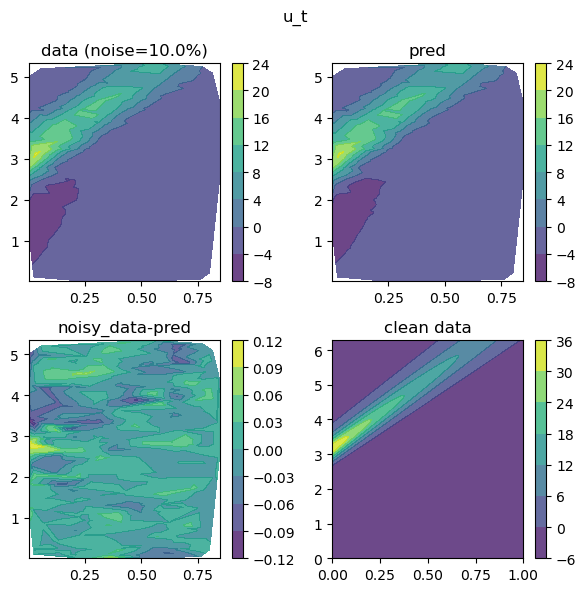

In [16]:
plt.figure(figsize=(6,6), dpi=100)
plt.suptitle('u_t')
for ifig, f, title in zip(
    range(221,224),
    [inputs['u_t'], 
     pred, 
#      u_t-pred.flatten()
     np.nan_to_num( (pred - inputs['u_t']) / np.mean(abs(np.array(inputs['u_t']))) ).flatten()
    ],
    ['data (noise={}%)'.format(noise_level*100),'pred','noisy_data-pred']
):
    plt.subplot(ifig)
    plt.title(title)
    plt.tricontourf(
        inputs['t'], inputs['x'], f, 
        alpha=0.8
    )
    plt.colorbar()
plt.subplot(224)
plt.title('clean data')
plt.contourf(
    t, x, u_t_analytical, 
    alpha=0.8
)
plt.colorbar()

plt.tight_layout()
plt.show()

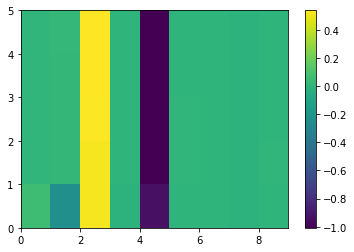

In [17]:
plt.pcolormesh(np.array(model.optimizer.history_)[:,0,:])
plt.colorbar()
plt.show()

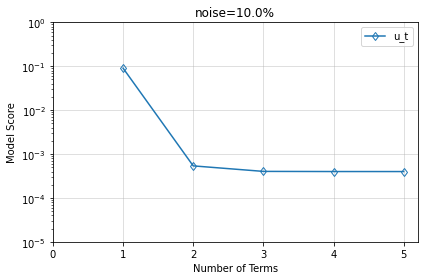

In [18]:
plt.figure()
plt.plot(
    N_terms, 
    1-np.array(score), 
    'd-', 
    mfc='none', 
    label='u_t'
)
plt.legend()
plt.yscale('log')
plt.title('noise={}%'.format(noise_level*100))
plt.xlabel('Number of Terms')
plt.ylabel('Model Score')
# plt.axvline(threshold,c='k',ls='--')
plt.tight_layout()
plt.ylim(1e-5,1e0)
plt.xticks([0,1,2,3,4,5])
plt.grid(True, alpha=0.5)
plt.show()
